In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
class callbacka(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.90):
            print("\nLoss is low stopping trainng")
            self.model.stop_training=True

In [ ]:
mcallbacks=callbacka()

In [2]:
base_dir='F:\chest_xray'
local_weight_file='DENSENT121_Weights.h5'
train_dir=os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
sample_image_pneumonia=os.listdir(os.path.join(train_dir,'PNEUMONIA'))
sample_image_healthy=os.listdir(os.path.join(train_dir,'NORMAL'))

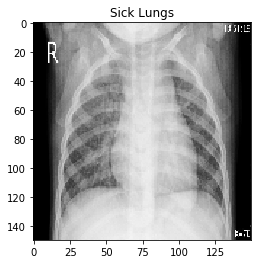

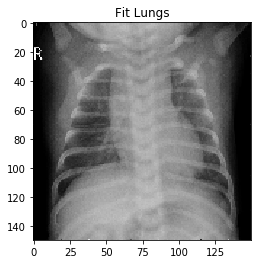

In [3]:
sample_image_pnue=sample_image_pneumonia[randint(0,(len(sample_image_pneumonia)-1))]
sample_image_normal=sample_image_healthy[randint(0,(len(sample_image_healthy)-1))]

img_to_array_sick=cv2.imread(os.path.join(os.path.join(train_dir,'PNEUMONIA'),sample_image_pnue))
img_to_array_fit=cv2.imread(os.path.join(os.path.join(train_dir,'NORMAL'),sample_image_normal))

plt.imshow(cv2.resize(img_to_array_sick,(150,150)))
plt.title("Sick Lungs")
plt.show()

plt.imshow(cv2.resize(img_to_array_fit,(150,150)))
plt.title("Fit Lungs")
plt.show()

In [4]:
pre_trained_model=DenseNet121(input_shape=(100,100,3),include_top=False,weights=None)
pre_trained_model.load_weights(local_weight_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [5]:
last_layer=pre_trained_model.get_layer('conv3_block12_concat')
last_output=last_layer.output
x=layers.Flatten()(last_output)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dropout(0.3)(x)
x=layers.Dense(1,activation='sigmoid')(x)

model=Model(pre_trained_model.input,x)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   samplewise_center=True,samplewise_std_normalization=True)
test_datagen = ImageDataGenerator(rescale = 1./255,samplewise_center=True,samplewise_std_normalization=True)
train_generator=train_datagen.flow_from_directory(train_dir,batch_size=20,class_mode='binary',target_size=(100,100))

Found 2682 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


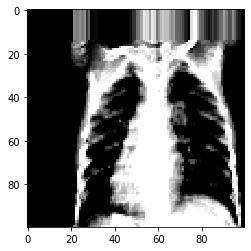

In [7]:
batch=train_generator.next()
data_sample=batch[0]
train_datagen.fit(data_sample)
x,y=train_generator.__getitem__(1)
plt.imshow(x[1])

In [8]:
validation_generator=test_datagen.flow_from_directory(test_dir,batch_size=10,class_mode='binary',target_size=(100,100))

Found 624 images belonging to 2 classes.


In [9]:
history=model.fit(train_generator,validation_data=validation_generator,steps_per_epoch=134,epochs=20,validation_steps=60,verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 134 steps, validate for 60 steps
Epoch 1/20
134/134 - 157s - loss: 1.0171 - accuracy: 0.8242 - val_loss: 0.2490 - val_accuracy: 0.9017
Epoch 2/20
134/134 - 148s - loss: 0.2169 - accuracy: 0.9192 - val_loss: 0.3592 - val_accuracy: 0.8450
Epoch 3/20
134/134 - 148s - loss: 0.1969 - accuracy: 0.9245 - val_loss: 0.4911 - val_accuracy: 0.7750
Epoch 4/20
134/134 - 150s - loss: 0.2327 - accuracy: 0.9132 - val_loss: 0.4861 - val_accuracy: 0.7633
Epoch 5/20
134/134 - 185s - loss: 0.1926 - accuracy: 0.9249 - val_loss: 0.2977 - val_accuracy: 0.8750
Epoch 6/20
134/134 - 168s - loss: 0.2177 - accuracy: 0.9128 - val_loss: 0.2346 - val_accuracy: 0.9017
Epoch 7/20
134/134 - 149s - loss: 0.1820 - accuracy: 0.9305 - val_loss: 0.5117 - val_accuracy: 0.7683
Epoch 8/20
134/134 - 151s - loss: 0.1556 - accuracy: 0.9421 - val_loss: 0.2992 - val_accuracy: 0.8767
Epoch 9/20
134/134 - 155s - loss: 0.1417 - accuracy: 0.9482 - val_loss: 0.5824 - val_accura

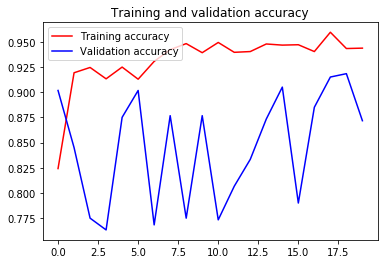

<Figure size 432x288 with 0 Axes>

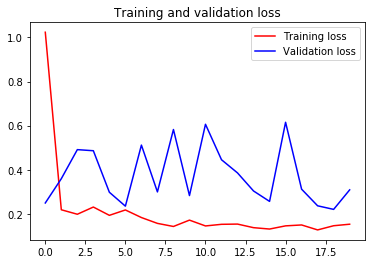

<Figure size 432x288 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs,loss, 'r', label="Training loss")
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()